In [5]:
import sys
sys.path.append('../algorithms/py')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [6]:
import rutils as rt
import decomposition as dc

# Data Loading

In [5]:
edata_df = pd.read_csv('../mutual-data/merged_edata.tsv', sep='\t', index_col=0)
mdata_df = pd.read_csv('../mutual-data/merged_mdata.tsv', sep='\t', index_col=0)
print( np.all(edata_df.columns == mdata_df.index) )

with open('../wgcna/common_genes.txt') as f:
	filter_genes = f.readlines()

gene_names = np.array([l for line in filter_genes if (l:=line.strip()) != ''])
print(f'{gene_names.size=}')

edata_df = edata_df.loc[gene_names,]
X = edata_df.T.to_numpy()
y = np.int_(mdata_df.condition == 'SC')
np.bincount(y)

True
gene_names.size=101


array([33, 14])

# Find out best n component

In [6]:
B = 1000
n_components_range = range(1, 4)
f1_scores = np.zeros((B, len(n_components_range)))
rnd = rt.set_seed(27624920)

for i in range(B):
    boot_x, oob_x, boot_y, oob_y = rt.bootstrap_resample(X, y, rnd_engine=rnd)
    # idx = np.setdiff1d(range(X.shape[0]), [i])
    # boot_x, boot_y = X[idx, :], y[idx]
    
    for j, ncomp in enumerate(n_components_range):
        model = dc.PLSClassifier(n_components=ncomp, std=True, vip=False)
        model.fit(boot_x, boot_y)
        y_pred = model.predict(oob_x)
        # pred_class = (pred > 0.5).astype(int)
        f1 = f1_score(oob_y, y_pred)
        f1_scores[i, j] = f1
    rt.iterLog(i)

print()
optimal_ncomp = n_components_range[np.argmax(np.mean(f1_scores, axis=0))]
print(np.mean(f1_scores, axis=0))
print(np.median(f1_scores, axis=0))
optimal_ncomp

Iteration - 0

Iteration - 999
[0.60720095 0.5965903  0.62456081]
[0.61538462 0.6        0.66666667]


3

In [7]:
selected_genes = []
B = 1000
rnd = rt.set_seed(59791884)

for i in range(B):
    boot_x, _, boot_y, _ = rt.bootstrap_resample(X, y, oob=False, rnd_engine=rnd)
    
    model = dc.PLSClassifier(n_components=optimal_ncomp, std=True)
    model.fit(boot_x, boot_y)
    
    vip = model.vip_
    selected_genes.append(np.float_(vip > 1))
    rt.iterLog(i)

selected_genes = np.array(selected_genes)
selection_freq = np.mean(selected_genes, axis=0)

Iteration - 999

In [8]:
print(selection_freq.max())
selection_freq

0.994


array([0.994, 0.313, 0.223, 0.515, 0.716, 0.763, 0.454, 0.289, 0.296,
       0.209, 0.283, 0.267, 0.626, 0.606, 0.664, 0.305, 0.594, 0.498,
       0.3  , 0.167, 0.599, 0.197, 0.519, 0.788, 0.699, 0.116, 0.227,
       0.224, 0.201, 0.334, 0.209, 0.902, 0.531, 0.395, 0.214, 0.125,
       0.274, 0.59 , 0.642, 0.149, 0.463, 0.679, 0.278, 0.182, 0.247,
       0.505, 0.35 , 0.27 , 0.661, 0.605, 0.703, 0.299, 0.592, 0.39 ,
       0.422, 0.228, 0.283, 0.752, 0.252, 0.256, 0.347, 0.393, 0.675,
       0.261, 0.391, 0.145, 0.307, 0.327, 0.294, 0.198, 0.28 , 0.265,
       0.179, 0.833, 0.338, 0.21 , 0.226, 0.704, 0.151, 0.283, 0.177,
       0.224, 0.156, 0.366, 0.176, 0.369, 0.18 , 0.236, 0.353, 0.179,
       0.459, 0.227, 0.199, 0.141, 0.269, 0.243, 0.457, 0.201, 0.304,
       0.595, 0.331])

In [11]:
score_array = []
thrshld = []

for i in np.arange(0.5, 1, 0.01):

    rpls_model = dc.PLSClassifier(n_components=optimal_ncomp, threshold=0.5, std=False)

    biomarker_genes = np.where(selection_freq >= i)[0]
    if len(biomarker_genes) < optimal_ncomp: break
    scores = rt.evaluateBootstrap(
        X, y, rpls_model, feature_indices=biomarker_genes, 
        seed=96860418, n_boot=400, metric=rt.pr_auc, use_proba=True
    )

    score_array.append(scores)
    thrshld.append(i)
    rt.iterLog(i)

score_array = np.array(score_array)

Iteration - 0.8300000000000003

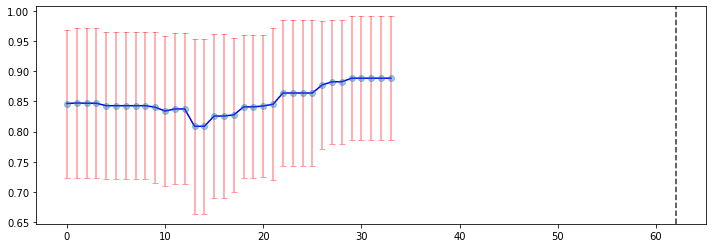

In [12]:
rt.errorPlot(score_array, axis=1, figsize=(12, 4), vline=62)

In [18]:
selection_freq_thrs = thrshld[::-1][np.argmax(score_array.mean(1)[::-1])]
print( selection_freq_thrs )

0.8300000000000003


In [19]:
t_idx = np.where(selection_freq >= selection_freq_thrs)[0]
print(len(t_idx))
rt.writeln(sorted(gene_names[t_idx]))

3
ALDH3A1
HRAS
TXNRD1


# EVALUATIONS

In [20]:
rpls_model = dc.PLSClassifier(n_components=3, threshold=0.5, std=False)
boot, oob = rt.evaluateBootstrap(
    X, y, rpls_model, selection_freq >= selection_freq_thrs, n_boot=1000, metric=f1_score, use_proba=False, boot_score=True,
    seed=843131
)
boot.mean(), oob.mean()

(0.9018547518644766, 0.8315716574275398)

In [21]:
train_score, loo_score = rt.evaluateLOO(
    X, y, rpls_model, selection_freq >= selection_freq_thrs, metric=f1_score, use_proba=False, verbose=0, train_score=True
)
print(train_score.mean())
train_score, loo_score

0.9222840516457533


(array([0.92307692, 0.92307692, 0.92307692, 0.92307692, 0.92307692,
        0.88888889, 0.92307692, 0.92307692, 0.92307692, 0.92307692,
        0.92307692, 0.92307692, 0.92307692, 0.92307692, 0.92307692,
        0.92307692, 0.92307692, 0.92307692, 0.92307692, 0.92307692,
        0.92307692, 0.91666667, 0.91666667, 0.96      , 0.91666667,
        0.91666667, 0.91666667, 0.91666667, 0.92307692, 0.92307692,
        0.96      , 0.91666667, 0.91666667, 0.92307692, 0.92307692,
        0.92307692, 0.92307692, 0.92307692, 0.92307692, 0.92307692,
        0.91666667, 0.92307692, 0.92307692, 0.92307692, 0.91666667,
        0.91666667, 0.91666667]),
 0.8888888888888888)

# ROC AUC

In [23]:
rpls_model = dc.PLSClassifier(n_components=3, threshold=0.5, std=True)
rpls_model.fit(X[:, selection_freq >= selection_freq_thrs], y)
y_pred = rpls_model.predict(X[:, selection_freq >= selection_freq_thrs])
confusion_matrix(y, y_pred)

array([[33,  0],
       [ 2, 12]])

In [24]:
y_scores = rpls_model.predict_proba(X[:, selection_freq >= selection_freq_thrs])[:, 1]
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y, y_scores)
pr_auc = auc(recall, precision)

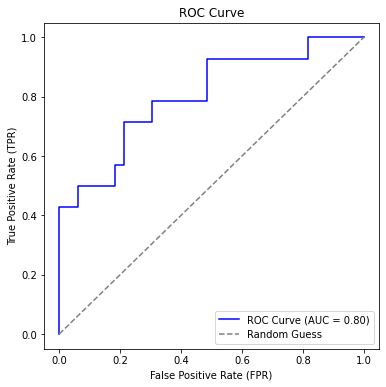

In [25]:
# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

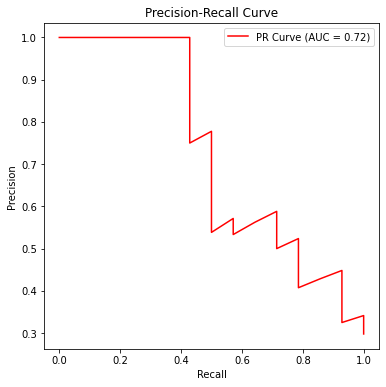

In [26]:
# Plot PR curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='red', label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()